In [3]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# List of parameter dictionaries to test
args = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


# Load the dataset
df = pd.read_csv('train.csv')

# Select only the soil_type columns
soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]

# Count the number of 0's and 1's in each soil_type column
zero_one_counts = pd.DataFrame({
    'Zeros': (df[soil_columns] == 0).sum(),
    'Ones': (df[soil_columns] == 1).sum()
})


# Check for NaNs and fill if needed
df = df.fillna(0)  # Replace NaNs with 0, or use another method as appropriate

# Step 1: Apply log transformation to skewed columns, handling negative values by adding a constant
skewed_columns = [
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points',
    'Hillshade_3pm',
    "Hillshade_9am",
    "Hillshade_Noon"
]

sparse_columns = zero_one_counts[zero_one_counts['Ones'] < 55].index
df = df.drop(columns=sparse_columns)

# Apply the log transformation and handle negative values by shifting
for col in skewed_columns:
    # Shift values if necessary to make them positive before applying log
    min_value = df[col].min()
    shift = 1 - min_value if min_value <= 0 else 0
    df[f'log_{col}'] = np.log(df[col] + shift + 1)

# Step 2: Drop original skewed columns
df = df.drop(columns=skewed_columns)


# Separating the target column 'Cover_Type' from the features
X = df.drop(columns=['Cover_Type'])  # Drop target and non-feature columns
y = df['Cover_Type']  # Target column

# Normalize the numerical features
scaler = StandardScaler()
X_scaled = X.copy()

# List of numerical columns to be scaled
numerical_columns = [
    'Elevation', 'Aspect', 'Slope', 'log_Horizontal_Distance_To_Hydrology',
    'log_Vertical_Distance_To_Hydrology', 'log_Horizontal_Distance_To_Roadways',
    'log_Hillshade_9am', 'log_Hillshade_Noon', 'log_Hillshade_3pm', 
    'log_Horizontal_Distance_To_Fire_Points'
]

# Apply scaling only to the numerical columns
X_scaled[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Initialize the LGBMClassifier with the current parameters
rf_model = RandomForestClassifier(**args)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_train = rf_model.predict(X_train)
# Evaluate the model's performance
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Train Accuracy: 1.0000
Test Accuracy: 0.8975


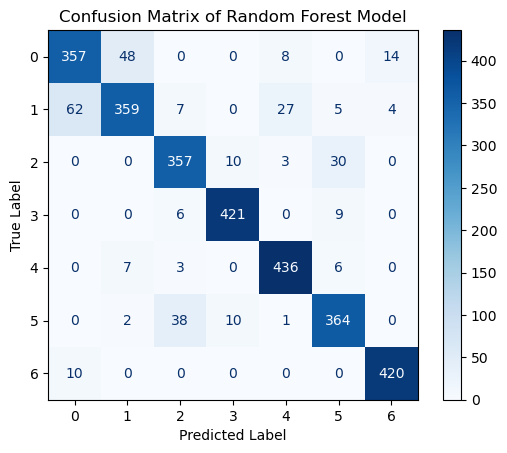

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Use a color map for clarity
plt.title("Confusion Matrix of Random Forest Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [5]:
# Initialize the LGBMClassifier with the current parameters
RF_model = RandomForestClassifier(**args)

# Train the model
RF_model.fit(X_scaled, y)

RandomForestClassifier(bootstrap=False, n_estimators=200)

In [4]:
df_subs = pd.read_csv('test-full.csv')
df_subs = df_subs.drop(columns=sparse_columns)

# Apply the log transformation and handle negative values by shifting
for col in skewed_columns:
    # Shift values if necessary to make them positive before applying log
    min_value = df_subs[col].min()
    shift = 1 - min_value if min_value <= 0 else 0
    df_subs[f'log_{col}'] = np.log(df_subs[col] + shift + 1)

# Step 2: Drop original skewed columns
df_subs = df_subs.drop(columns=skewed_columns)
df_subs_scaled = df_subs.copy()
df_subs_scaled[numerical_columns] = scaler.transform(df_subs[numerical_columns])

In [7]:
submission_preds = pd.DataFrame(rf_model.predict(df_subs_scaled), columns=['Cover_Type'])

In [8]:
df.to_csv('filename.csv', index=False)

In [10]:
submission_preds.to_csv('submission07-11-24.csv', index=True)

In [12]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('submission07-11-24.csv')

# Increment the 'Id' column by 1
df['Id'] = df['Id'] + 1

# Save the modified DataFrame back to CSV
df.to_csv('submission07-11-24_8.csv', index=False)
